In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
from torch.distributions.multivariate_normal import MultivariateNormal


import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models_v2 import *
from torchcfm.utils import *

from tqdm import tqdm

savedir = "models/gauss-8gauss"
os.makedirs(savedir, exist_ok=True)



In [2]:
# Problem set up

dim = 2
batch_size = 256
n_iters = 5000

In [20]:
# Set up for reference distribution

mean = torch.zeros(dim)
cov = torch.eye(dim)

# Set up for reference distribution

ref_dist = MultivariateNormal(mean, cov)
# x0 = ref_dist.sample((batch_size,))

# Gauss 2

mean_2 = 3*torch.ones(dim)
cov_2 = torch.tensor([[1, -.25], [-0.25, 1]])



# Set up for reference distribution

gauss_target = MultivariateNormal(mean_2, cov_2)



### Conditional Flow Matching

First we implement the basic conditional flow matching. As in the paper, we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= q(x_0)q(x_1) \\
p_t(x | z) &= \mathcal{N}(x | t * x_1 + (1 - t) * x_0, \sigma^2) \\
u_t(x | z) &= x_1 - x_0
\end{align}
$$
When $\sigma = 0$ this is equivalent to zero-steps of rectified flow. We find that small $\sigma$ helps to regularize the problem ymmv.

  0%|          | 0/10000 [00:00<?, ?it/s]

 50%|████▉     | 4992/10000 [00:40<00:53, 93.82it/s] 

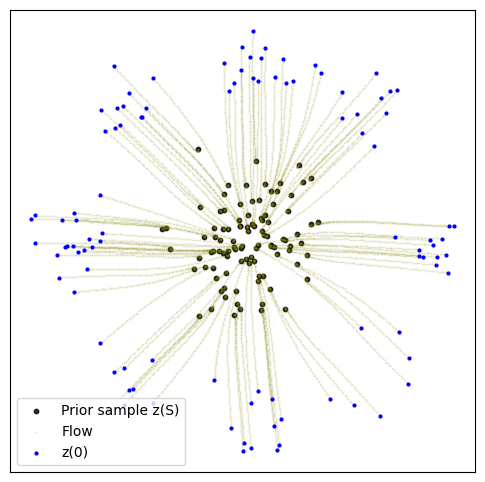

100%|█████████▉| 9993/10000 [01:29<00:00, 79.17it/s] 

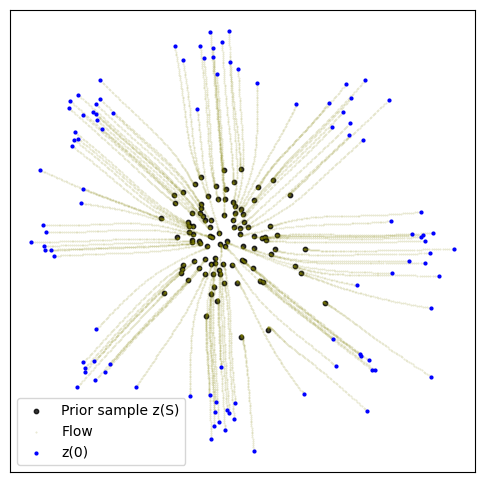

100%|██████████| 10000/10000 [01:30<00:00, 110.20it/s]


In [4]:
# sig_min for the data points
sigma = 0.1
model = MLP(dim= dim,time_varying= True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
FM = ConditionalFlowMatcher(sigma= sigma)


for k in tqdm(range(n_iters)):

    optimizer.zero_grad()

    x0 = ref_dist.sample((batch_size,))
    x1 = sample_8gaussians(batch_size)

    # uniform sampling in time, evaluate x(t) and u(t)
    t,xt,ut = FM.sample_location_and_conditional_flow(x0,x1)
    # fomr (x,t) pairs and evaluate  in the MLP
    vt = model(torch.cat([xt,t[:,None]],dim = -1))

    loss = torch.mean(torch.norm(vt - ut)**2)
    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        # end = time.time()
        # print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        # start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                ref_dist.sample((100,)),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())

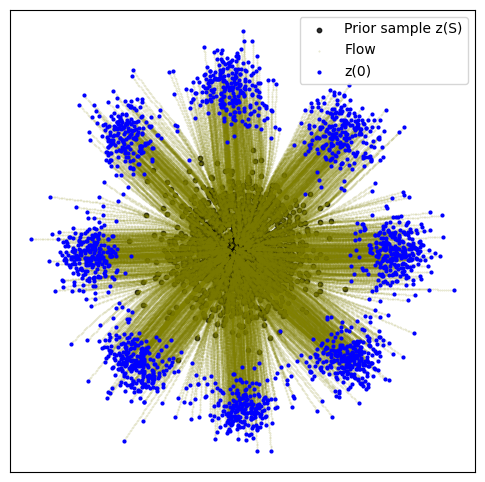

In [7]:
node = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4        )
with torch.no_grad():
    traj = node.trajectory(ref_dist.sample((10000,)),
                t_span=torch.linspace(0, 1, 100), )
plot_trajectories(traj.cpu().numpy())

### Optimal Transport Conditional Flow Matching

Next we implement optimal transport conditional flow matching. As in the paper, here we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= \pi(x_0, x_1) \\
p_t(x | z) &= \mathcal{N}(x | t * x_1 + (1 - t) * x_0, \sigma^2) \\
u_t(x | z) &= x_1 - x_0
\end{align}
$$
where $\pi$ is the joint of an exact optimal transport matrix. We first sample random $x_0, x_1$, then resample according to the optimal transport matrix as computed with the python optimal transport package. We use the 2-Wasserstein distance with an $L^2$ ground distance for equivalence with dynamic optimal transport.

 50%|████▉     | 2496/5000 [01:09<01:09, 35.98it/s]

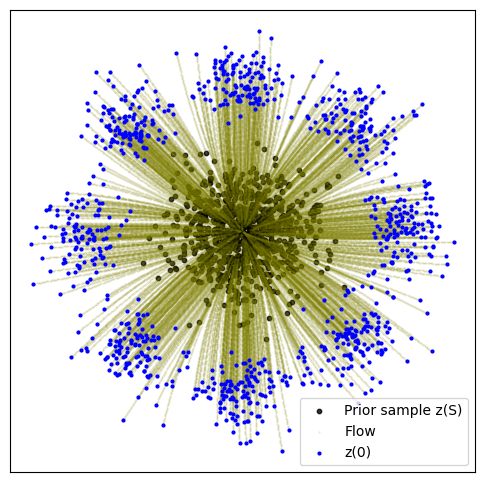

 67%|██████▋   | 3366/5000 [01:35<00:46, 35.27it/s]


KeyboardInterrupt: 

In [8]:
sigma = 0.1
dim = 2
batch_size = 256*2
model = ResNet(dim= dim,hidden=1,time_varying= True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma= sigma)

for k in tqdm(range(n_iters)):
    optimizer.zero_grad()

    x0 = ref_dist.sample((batch_size,))
    x1 = sample_8gaussians(batch_size)
    # Sample time of evaluations, locations, and velocity field
    t,xt,ut = FM.sample_location_and_conditional_flow(x0,x1)
    # Evaluate the NN model
    vt = model(torch.cat([xt,t[:,None]],dim = -1))
    # Compute the loss
    loss = torch.mean(torch.norm(vt - ut)**2)
    loss.backward()
    optimizer.step()
    
    if (k + 1) % 2500 == 0:
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                ref_dist.sample((1000,)),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())


### Schrödinger Bridge Conditional Flow Matching

Next we implement Schrödinger Bridge conditional flow matching. As in the paper, here we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= \pi_{2 \sigma^2} (x_0, x_1) \\
p_t(x | z) &= \mathcal{N}( x \mid t x_1 + (1 - t) x_0, t(1-t)\sigma^2)\\
u_t(x | z) &= \frac{1-2t}{2t(1-t)}(x - ( t x_1 + (1-t)x_0) ) + (x_1 - x_0)
\end{align}
$$
where $\pi_{2 \sigma^2}$ is the joint of a **Sinkhorn** optimal transport matrix with regularization $2 \sigma^2$. As in OT-CFM We first sample random $x_0, x_1$, then resample according to the optimal transport matrix as computed with the python optimal transport package. We use the 2-Wasserstein distance with an $L^2$ ground distance for equivalence with the probability flow of a Schrödinger Bridge with reference measure $\sigma W$.

Note that the drift $v_\theta(t,x)$ we learn is *not* equivalent to the drift of the stochastic system, instead it is the drift of the equivalent probability flow ODE, however they are related through $p_t(x)$.

Also note that we use a larger $\sigma$ here both for convergence of the Sinkhorn algorithm and to make the differences more visible.

 50%|████▉     | 2493/5000 [00:29<00:25, 99.30it/s] 

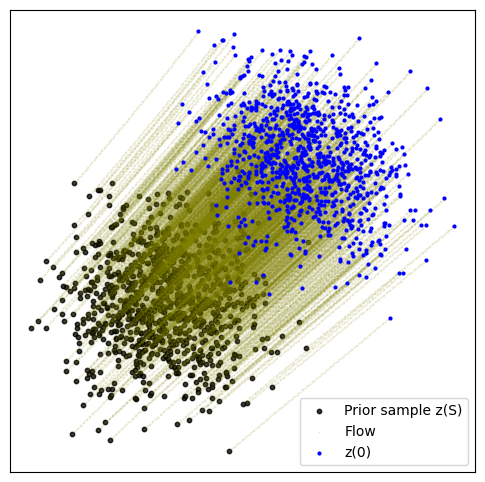

 54%|█████▍    | 2707/5000 [00:33<00:24, 91.84it/s] /work2/Sebas/anaconda3/envs/Hamiltonian_Flows_Wass/lib/python3.10/site-packages/ot/bregman.py:536: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
100%|█████████▉| 4998/5000 [01:01<00:00, 79.00it/s] 

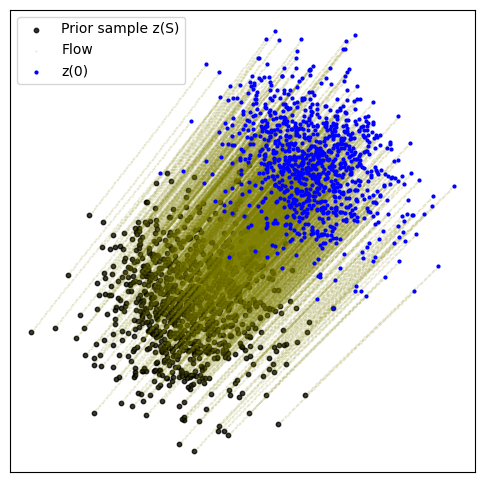

100%|██████████| 5000/5000 [01:02<00:00, 79.80it/s]


In [23]:
sigma = 0.5
model = ResNet(dim= dim,hidden=1,time_varying= True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
FM = SchrodingerBridgeConditionalFlowMatcher(sigma= sigma,ot_method= "sinkhorn")

for k in tqdm(range(n_iters)):
    optimizer.zero_grad()

    x0 = ref_dist.sample((batch_size,))
    x1 = gauss_target.sample((batch_size,))

    t,xt,ut = FM.sample_location_and_conditional_flow(x0,x1)

    vt = model(torch.cat([xt,t[:,None]],dim = -1))
    loss = torch.mean(torch.norm(vt - ut)**2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 2500 == 0:
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                ref_dist.sample((1000,)),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())


    

### Stochastic Interpolants (Albergo et al. 2023)

Next we try a variant suggested by Albergo et al. 2023, Stochastic Interpolants. This is an interesting interpolant because it has some variance preservation properties. Note that the authors consider $\sigma = 0$ (i.e. a Dirac around $\mu_t$) but we keep the general form for consistency. We also refer to this $t$ schedule as "Variance Preserving" and call this VP-CFM. The authors also consider optimizing over more general interpolants $I_t = \alpha(t) x_0 + \beta(t) x_1$ with minor constraints. In our notation, we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= q(x_0)q(x_1) \\
p_t(x | z) &= \mathcal{N}(x | \cos \left (\frac{\pi t}{2}  \right ) x_0 + \sin \left (\frac{\pi t}{2}  \right ) x_1, \sigma^2) \\
u_t(x | z) &= \frac{\pi}{2} \left (\cos (\frac{\pi t}{2}) x_1 - \sin(\frac{\pi t}{2}) x_0 \right )
\end{align}
$$

 50%|████▉     | 2494/5000 [00:12<00:14, 171.73it/s]/work2/Sebas/anaconda3/envs/Hamiltonian_Flows_Wass/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


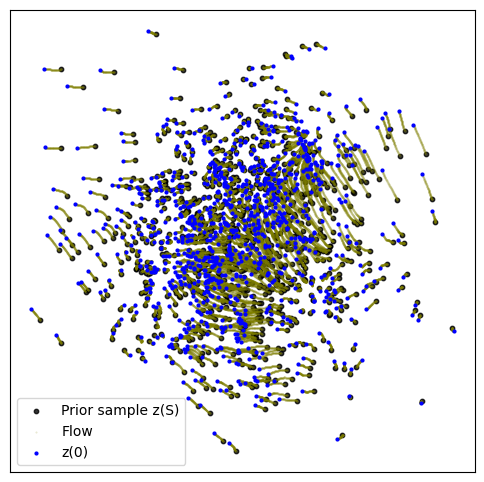

100%|█████████▉| 4994/5000 [00:27<00:00, 200.02it/s]

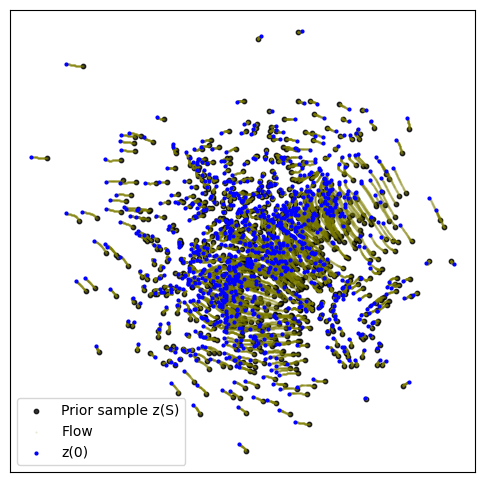

100%|██████████| 5000/5000 [00:29<00:00, 171.85it/s]


In [11]:
action = ResNet(dim= dim,hidden=1,time_varying= True)
# Returns the grad a of sum of the action evaluated at the points x
model = GradModel(action=action)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for k in tqdm(range(n_iters)):
    optimizer.zero_grad()

    t = torch.rand(batch_size,1).requires_grad_(True)
    x0 = ref_dist.sample((batch_size,))
    x1 = sample_8gaussians(batch_size)
    # Important to detach, if not xt is not a leaf node
    xt = (t*x1 + (1-t)*x0).detach().requires_grad_(True)
    st = torch.sum(action(torch.cat([xt,t],dim = -1)))
    dsdx,dsdt = torch.autograd.grad(st,(xt,t),create_graph=True)
    xt.requires_grad , t.requires_grad = False,False
    a0 = action(torch.cat([x0,torch.zeros_like(t)],dim = -1))
    a1 = action(torch.cat([x1,torch.ones_like(t)],dim = -1))        
    loss = a0-a1+0.5*(dsdx**2).sum(1,keepdim=True) + dsdt
    loss = loss.mean()
    optimizer.step()
    if (k + 1) % 2500 == 0:
        node = NeuralODE(
            torch_wrapper(model), solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        # the solver requires to compute grad, why?
        #with torch.no_grad():
        traj = node.trajectory(
            ref_dist.sample((1000,)),
            t_span=torch.linspace(0, 1, 100),
        ).detach()
        plot_trajectories(traj.cpu().numpy())

    




 50%|████▉     | 2480/5000 [00:09<00:08, 300.27it/s]/work2/Sebas/anaconda3/envs/Hamiltonian_Flows_Wass/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


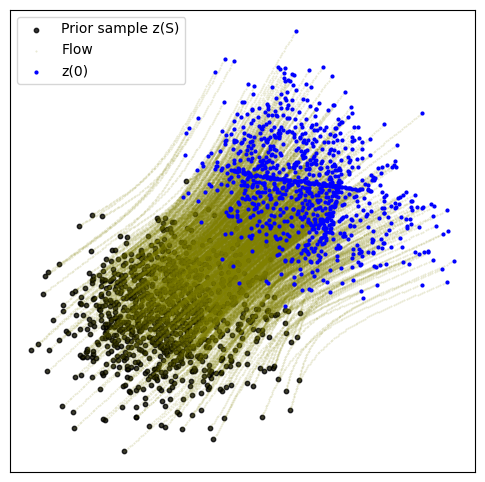

100%|█████████▉| 4998/5000 [00:20<00:00, 276.84it/s]

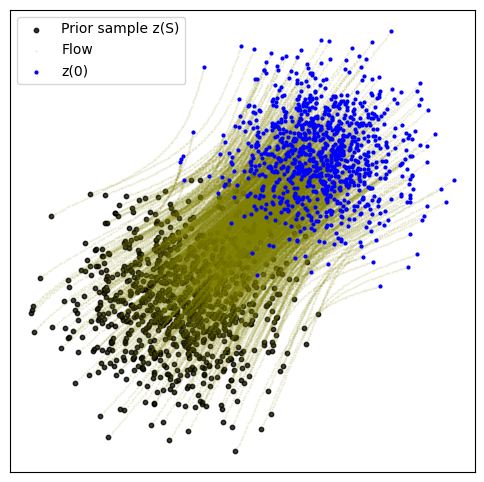

100%|██████████| 5000/5000 [00:21<00:00, 233.76it/s]


In [22]:
class MLP2(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.ReLU(),
            torch.nn.Linear(w, w),
            torch.nn.SiLU(),
            torch.nn.Linear(w, w),
            torch.nn.SiLU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)


action = MLP2(dim= dim,out_dim=1,time_varying= True)
model = GradModel(action=action)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for k in tqdm(range(n_iters)):
    optimizer.zero_grad()

    t = torch.rand(batch_size,1).requires_grad_(True)
    x0 = ref_dist.sample((batch_size,))
    x1 = gauss_target.sample((batch_size,))
    # Important to detach, if not xt is not a leaf node
    xt = (t*x1 + (1-t)*x0).detach().requires_grad_(True)
    st = torch.sum(action(torch.cat([xt,t],dim = -1)))
    # Why does the graph needs to be created and retained?
    dsdx,dsdt = torch.autograd.grad(st,(xt,t),create_graph=True, retain_graph=True)
    xt.requires_grad , t.requires_grad = False,False
    a0 = action(torch.cat([x0,torch.zeros(batch_size, 1)],dim = -1))
    a1 = action(torch.cat([x1,torch.ones(batch_size, 1)],dim = -1))        
    loss = a0-a1+0.5*(dsdx**2).sum(1,keepdim=True) + dsdt
    loss = loss.mean()
    loss.backward()
    optimizer.step()
    if (k + 1) % 2500 == 0:
        node = NeuralODE(
            torch_wrapper(model), solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        # the solver requires to compute grad, why?
        #with torch.no_grad():
        traj = node.trajectory(
            ref_dist.sample((1000,)),
            t_span=torch.linspace(0, 1, 100),
        ).detach()
        plot_trajectories(traj.cpu().numpy())

    